In [49]:
from astropy.table import Table, vstack, Column, MaskedColumn, pprint
import numpy as np

import matplotlib 
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian1DKernel

from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages

import os
import requests
import sys
sys.path.append('/Users/s2537809/DESI/desispec/py')
sys.path.append('/Users/s2537809/DESI/desimodel/py')
sys.path.append('/Users/s2537809/DESI/desitarget/py')
sys.path.append('/Users/s2537809/DESI/desiutil/py')

#from desispec.io import read_spectra
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra


from scipy import interpolate
import astropy.units as u
path='/Users/s2537809/Documents/DESI-STACKING'#specify code directory
os.chdir(path)
import stack_code as sc
import importlib
import fnmatch
import extinction as ext
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy.modeling import models
from astropy.table import Table
from matplotlib import gridspec
import spectres
import time
import warnings


#pip install lmfit, extinction, sfdmap, spectres

import pandas as pd
crossmatch = Table.read('crossmatch_classifications.fits', format = 'fits' )

In [61]:
crossmatch

Source_Name_1,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,EBV_1,FUV_flux_corr,FUV_fluxerr_corr,FUV_mag_corr,FUV_magerr_corr,NUV_flux_corr,NUV_fluxerr_corr,NUV_mag_corr,NUV_magerr_corr,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation_1,help_id,RA_HELP,DEC_HELP,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST_1,Z_BEST_SOURCE,Z_SPEC,Z_SOURCE,Z_QUAL,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,2RXS_ID,XMMSL2_ID,ap_to_model_g,ap_to_model_err_g,ap_to_model_r,ap_to_model_err_r,ap_to_model_z,ap_to_model_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,XID+_rerun_mips,XID+_rerun_pacs,XID+_rerun_SPIRE,Source_Name_2,Radio_ID,S_150MHz,z_best_2,AGN_final,Mass_cons,SFR_cons,Radio_excess,Extended_radio,RadioAGN_final,Overall_class,TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV_2,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,

## Cell below verifies if Spectra are downloaded and downloads if they aren't

Only run if unsure if spectra are downloaded, to save time!

In [22]:
"""
Note: The lengths for indexing are:

HERG = 184

RQAGN = 814

LERG = 1293

SFG = 6294

"""


Overall_class = 'SFG'
my_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][1000:1200]
search_column_name = 'TARGETID'
search_values = np.array(my_table[f'{search_column_name}'])



def select_data(table, column_name, search_values):
    # Get the column data as a numpy array
    column_data = table[column_name]

    SURVEY = []
    PROGRAM = []
    HEALPIX = []
    n_values = []
    Z = []
    
    

    for search_value in search_values:
        # Find the indices where the condition is met (value == search_value)
        indices = np.where(column_data == search_value)[0]


        if len(indices) > 0:
            # Find the corresponding Survey, program, healpix, and Z values
            SURVEY.append(table['SURVEY'][indices[0]])
            PROGRAM.append(table['PROGRAM'][indices[0]])
            HEALPIX.append(table['HEALPIX'][indices[0]])
            Z.append(table['Z'][indices[0]])
            HEALPIX_str = str(table['HEALPIX'][indices[0]])
            n_str = HEALPIX_str[:3]
            n_values.append(int(n_str))
            
        else:
            # Handle the case where the search value was not found
            SURVEY.append(None)
            PROGRAM.append(None)
            HEALPIX.append(None)
            n_values.append(None)
            Z.append(None)
            
    

    return np.array(SURVEY), np.array(PROGRAM), np.array(HEALPIX), np.array(n_values), np.array(Z)


SURVEY = select_data(my_table, search_column_name, search_values)[0]
PROGRAM = select_data(my_table, search_column_name, search_values)[1]
HEALPIX = select_data(my_table, search_column_name, search_values)[2]
n = select_data(my_table, search_column_name, search_values)[3]
Z = select_data(my_table, search_column_name, search_values)[4]
print (SURVEY,PROGRAM,HEALPIX, n, Z)

for n, survey, program, healpix, Z, search_value in zip(n, SURVEY, PROGRAM, HEALPIX, Z, search_values):
        #download the file from the given Target ID
        target_url = f"https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/healpix/{survey}/{program}/{n}/{healpix}/coadd-{survey}-{program}-{healpix}.fits"
        
        # Define the folder name and file name
        folder_name = 'DESI_Downloads'
        file_name = f"coadd-{survey}-{program}-{healpix}.fits"
        print(search_value)


        # Check if the folder exists, and create it if it doesn't
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        # Check if the file exists in the folder
        file_path = os.path.join(folder_name, file_name)
        if os.path.exists(file_path):
            print(f"{file_name} already exists in {folder_name}. No need to download.")
        else:
            # File doesn't exist, download it
            try:
                response = requests.get(target_url)
                if response.status_code == 200:
                    with open(file_path, 'wb') as file:
                        file.write(response.content)
                    print(f"{file_name} downloaded to {folder_name}.")
                else:
                    print(f"Failed to download {file_name}. Status code: {response.status_code}")
            except Exception as e:
                print(f"An error occurred while downloading {file_name}: {str(e)}")

      

['sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3'
 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv1' 'sv1'
 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv1' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv1' 'sv1' 'sv1' 'sv1' 'sv3' 'sv1' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv1'
 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv1' 'sv1' 'sv1' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 's

/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_10277/1172372596.py:59: UserWarning: Warning: converting a masked element to nan.
  return np.array(SURVEY), np.array(PROGRAM), np.array(HEALPIX), np.array(n_values), np.array(Z), np.array(Mass_median)


In [57]:




def inv_var_weighted_average(flux1, ivar1, flux2, ivar2):
    weight1 = 1 / ivar1
    weight2 = 1 / ivar2
    total_weight = weight1 + weight2
    weighted_flux1 = flux1 * (weight1 / total_weight)
    weighted_flux2 = flux2 * (weight2 / total_weight)
    weighted_avg = weighted_flux1 + weighted_flux2
    return weighted_avg

# Isolating the non-overlapping wavelength ranges
def no_overlap_f(waveb,fluxb,waver,fluxr,wavez,fluxz):
    new_b_length = np.where(waveb<waver[0])
    b_wave = waveb[new_b_length]
    b_flux = fluxb[new_b_length]
    new_r_length = np.where((waver>waveb[-1])&(waver<wavez[0]))
    r_wave = waver[new_r_length]
    r_flux = fluxr[new_r_length]
    new_z_length = np.where(wavez>waver[-1])
    z_wave = wavez[new_z_length]
    z_flux = fluxz[new_z_length]

    return b_wave,b_flux,r_wave,r_flux,z_wave,z_flux


# Finding overlap range, flux, ivar

def overlap_av(wave1,wave2,flux1,flux2,ivar1,ivar2):

    overlap_idx_1 = np.where(wave1 >= wave2[0]) 
    overlap_wave = wave1[overlap_idx_1]
    overlap_flux_1 = flux1[overlap_idx_1]
    overlap_ivar_1 = ivar1[overlap_idx_1]

    overlap_idx_2 = np.where(wave2 <= wave1[-1]) 
    overlap_flux_2 = flux2[overlap_idx_2]
    overlap_ivar_2 = ivar2[overlap_idx_2]
    
    overlap_av_flux = inv_var_weighted_average(overlap_flux_1,overlap_ivar_1,overlap_flux_2,overlap_ivar_2)

    return overlap_av_flux, overlap_wave





In [58]:
#stacking functions

# Ignore warnings due to spec_var=0
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")


def get_spectra(table, column_name, search_values): 
    print('Number of spectra =', len(table))
    # Get the Target IDs as a numpy array
    column_data = table[column_name]

    SURVEY, PROGRAM, HEALPIX, n_values = [], [], [], []
    Z, RA, DEC, Source_ID = [], [], [], []


    for search_value in search_values:
        # Find the indices where the condition is met (value == search_value)
        # This is only relevant if input is doen by search value and not selected table
        indices = np.where(column_data == search_value)[0]

        if len(indices) > 0:
            # Find the corresponding Survey, program, healpix, Z , RA and Dec values
            SURVEY.append(table['SURVEY'][indices[0]])
            PROGRAM.append(table['PROGRAM'][indices[0]])
            HEALPIX.append(table['HEALPIX'][indices[0]])
            Z.append(table['Z'][indices[0]])
            RA.append(table['TARGET_RA'][indices[0]]) 
            DEC.append(table['TARGET_DEC'][indices[0]])
            Source_ID.append(table['TARGETID'][indices[0]])
            HEALPIX_str = str(table['HEALPIX'][indices[0]])
            n_str = HEALPIX_str[:3]
            n_values.append(int(n_str))
            
        else:
            # Handle the case where the search value was not found
            SURVEY.append(None)
            PROGRAM.append(None)
            HEALPIX.append(None)
            n_values.append(None)
            Z.append(None)   
            RA.append(None)
            DEC.append(None)
            Source_ID.append(None)
            
            
    
    z = np.array(Z)
    #print(z)
    RA = np.array(RA)
    DEC = np.array(DEC)
    id_spec = np.array(Source_ID)
    wave_spec, flux_spec, sigma_spec = [], [], []
    
    for index, (survey, program, healpix, search_value) in enumerate(zip(SURVEY, PROGRAM, HEALPIX, search_values)):
        
        folder_name = 'DESI_Downloads'
        file_name = f"coadd-{survey}-{program}-{healpix}.fits"
        coadd_obj = desispec.io.read_spectra(f'{folder_name}/{file_name}')
        coadd_tgts = coadd_obj.target_ids().data
        # Selecting the particular spectra of the targetid
        row = (coadd_tgts == search_value)
        coadd_spec = coadd_obj[row]   

        # Inverse Vartiance weighted average for overlap
        no_overlap = no_overlap_f(coadd_spec.wave['b'],coadd_spec.flux['b'][0],coadd_spec.wave['r'],coadd_spec.flux['r'][0],coadd_spec.wave['z'],coadd_spec.flux['z'][0])
        overlap_br= overlap_av(coadd_spec.wave['b'],coadd_spec.wave['r'],coadd_spec.flux['b'][0],coadd_spec.flux['r'][0],coadd_spec.ivar['b'][0],coadd_spec.ivar['r'][0])
        overlap_rz= overlap_av(coadd_spec.wave['r'],coadd_spec.wave['z'],coadd_spec.flux['r'][0],coadd_spec.flux['z'][0],coadd_spec.ivar['r'][0],coadd_spec.ivar['z'][0])
        
        # Concaternating Spectra
        flux_spectra = np.concatenate((no_overlap[1],overlap_br[0],no_overlap[3],overlap_rz[0],no_overlap[5]))
        wave_spectra = np.concatenate((no_overlap[0],overlap_br[1],no_overlap[2],overlap_rz[1],no_overlap[4]))

        # Using Desispec to get wavelengths, flux and sigma
        wave = wave_spectra
        wave = wave.flatten()
        #flux = coadd_spec.flux['r'][0]
        flux = convolve(flux_spectra, Gaussian1DKernel(5))
        #print(flux)
        flux = flux.flatten()
        sigma = (np.sqrt(1/coadd_spec.ivar['r']))
        sigma = sigma.flatten()
        if index % 2 == 0 and len(wave) > 0:
                wave = wave[:-1]
                flux = flux[:-1]
                sigma = sigma[:-1]
        sigma_spec.append(sigma)
        wave_spec.append(wave)
        flux_spec.append(flux)
        
    
    wave_spec = np.array(wave_spec,dtype=object)
    flux_spec = np.array(flux_spec,dtype=object)
    sigma_spec = np.array(sigma_spec,dtype=object)
    # alternatively tried wave_spec = wave_spec.tolist()

    
    
    return wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec


def get_stack(spec, zbins=None):# can add redshift ranges i.e zbins = [[0.0,0.1],[0.1,0.2]]
    wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec= spec
    stack = sc.stack_spectra(wave_spec,flux_spec,sigma_spec,
                               z, RA, DEC, zbins = zbins)
    return stack

## Spectra Selection and Application of Stacking

In [59]:

"""

"""
Overall_class = 'LERG'
my_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][0:10]
search_column_name = 'TARGETID'
search_values = np.array(my_table[f'{search_column_name}'])


SFG_spec=get_spectra(my_table,search_column_name,search_values) #extracts relevant spectra


SFG_stack = get_stack(SFG_spec) #stacks spectra

#stack spectra in two redshift bins (i.e 0<z<0.1 and 0.1<z<0.2) - need to alter
SFG_stacks = get_stack(SFG_spec, zbins=[[0.0,0.5],[0.5,1.0],[1.0,4.0]])
#soemtimes the redshift is less than 0?

## try adjusting these boundarys and adding more bins instead of binning seperately

Number of spectra = 10
INFO:spectra.py:372:read_spectra: iotime 2.799 sec to read coadd-sv3-dark-11520.fits at 2024-01-05T17:49:34.255834


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_10277/3503144271.py:80: RuntimeWarning: divide by zero encountered in divide
  sigma = (np.sqrt(1/coadd_spec.ivar['r']))


INFO:spectra.py:372:read_spectra: iotime 2.067 sec to read coadd-sv3-bright-11520.fits at 2024-01-05T17:49:38.106625


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_10277/2895303852.py:2: RuntimeWarning: divide by zero encountered in divide
  weight1 = 1 / ivar1
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_10277/2895303852.py:5: RuntimeWarning: invalid value encountered in divide
  weighted_flux1 = flux1 * (weight1 / total_weight)


INFO:spectra.py:372:read_spectra: iotime 2.036 sec to read coadd-sv3-bright-11520.fits at 2024-01-05T17:49:41.957337
INFO:spectra.py:372:read_spectra: iotime 2.941 sec to read coadd-sv3-dark-11520.fits at 2024-01-05T17:49:46.941694
INFO:spectra.py:372:read_spectra: iotime 2.307 sec to read coadd-sv3-bright-11520.fits at 2024-01-05T17:49:51.484618
INFO:spectra.py:372:read_spectra: iotime 0.672 sec to read coadd-sv1-other-11520.fits at 2024-01-05T17:49:53.842763
INFO:spectra.py:372:read_spectra: iotime 1.699 sec to read coadd-sv3-bright-11520.fits at 2024-01-05T17:49:55.811217
INFO:spectra.py:372:read_spectra: iotime 1.618 sec to read coadd-sv3-bright-11520.fits at 2024-01-05T17:49:57.886364
INFO:spectra.py:372:read_spectra: iotime 0.598 sec to read coadd-sv1-other-11520.fits at 2024-01-05T17:49:59.674951
INFO:spectra.py:372:read_spectra: iotime 0.594 sec to read coadd-sv1-other-11520.fits at 2024-01-05T17:50:00.482425
flux_spec: [array([0.43373498, 0.45495113, 0.46599099, ..., 0.5786859

In [64]:


# Select varibale to sort by
var_bin = 'Total_flux'
crossmatch = crossmatch[np.array(np.argsort(crossmatch[f'{var_bin}']))]


Overall_class = 'LERG'
my_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][0:10] #index the size of current bin
search_column_name = 'TARGETID'
search_values = np.array(my_table[f'{search_column_name}'])



In [66]:
crossmatch['Total_flux']

3.6849172171444743e-05
5.491049998366575e-05
5.8902407509107296e-05
6.31469936726868e-05
6.378532764405651e-05
7.029566505727315e-05
7.036964646880293e-05
7.175270895871147e-05
7.240876438656812e-05
7.306245943409034e-05
7.396086086569355e-05


In [4]:
print(SFG_stack['zbin=0']['wln'])
print(SFG_stack['zbin=0']['flux'][0:50])
print(SFG_spec[3])

[2804.5 2805.5 2806.5 ... 6089.5 6090.5 6091.5]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
[0.79144267 0.2838768  0.25055055 0.64592003 0.26254114 1.05450747
 0.39785078 0.29966714 0.76743957 0.77043976]


## Plot Stacked Spectra

All plots saved in DESI-LERG-stacked-plots-debugging.pdf


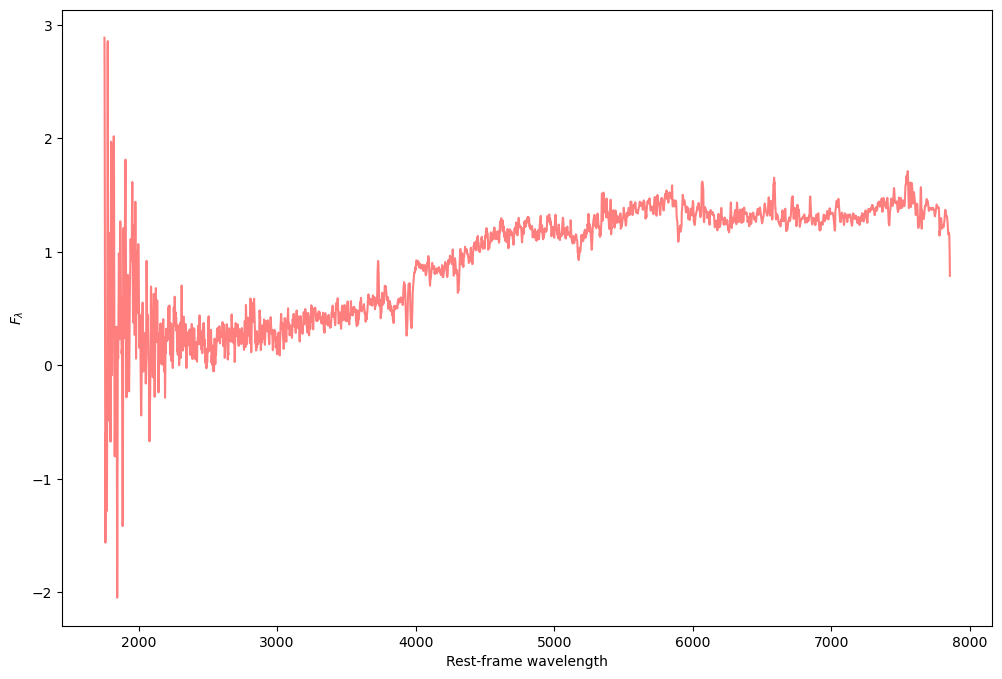

In [60]:
plt.figure(figsize=(12,8))
plt.plot(SFG_stack['zbin=0']['wln'],SFG_stack['zbin=0']['flux'], color='red', alpha=0.5)
plt.ylabel('$F_{\lambda}$')
plt.xlabel('Rest-frame wavelength')

# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-plots-debugging.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(SFG_stack['zbin=0']['wln'],SFG_stack['zbin=0']['flux'], color='red', alpha=0.5)
        ax.set_ylabel('$F_{\lambda}$')
        ax.set_xlabel('Rest-frame wavelength')

     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.close()

# All the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')


All plots saved in DESI-LERG-stacked-zbin-plots.pdf


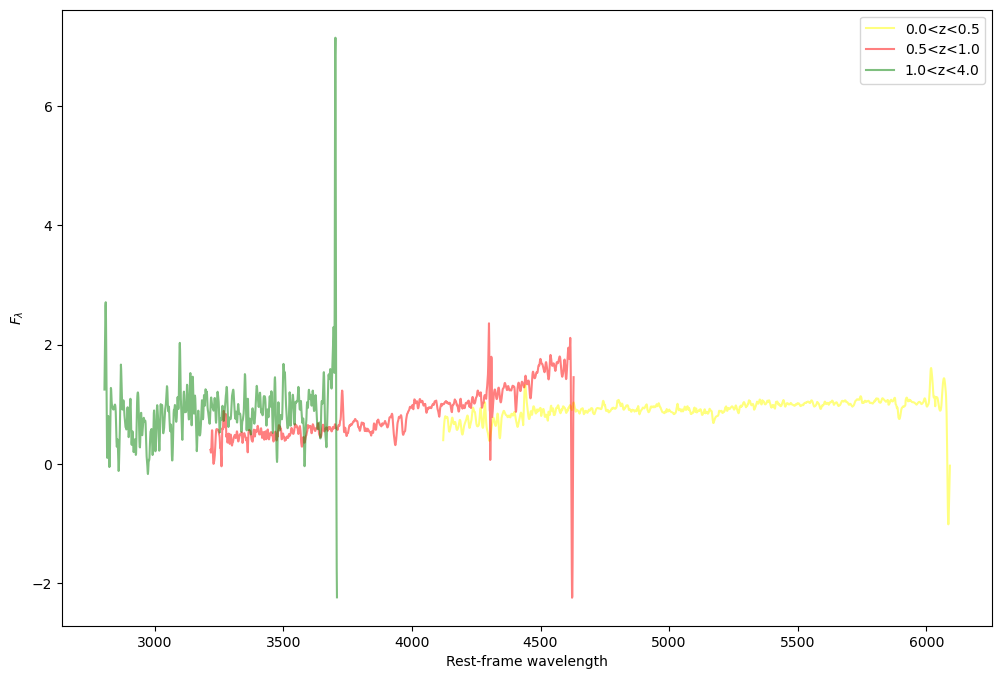

In [6]:
"""

The lack of simulated correction might be having an impact ?
Need to use different redshift bins - why does DESI have negative redshifts?
Why is there such a difference between the bins?

"""


plt.figure(figsize=(12,8))
plt.plot(SFG_stacks['zbin=0']['wln'],SFG_stacks['zbin=0']['flux'], label='0.0<z<0.5', color='yellow', alpha=0.5)
plt.plot(SFG_stacks['zbin=1']['wln'],SFG_stacks['zbin=1']['flux'], label='0.5<z<1.0', color='red', alpha=0.5)
plt.plot(SFG_stacks['zbin=2']['wln'],SFG_stacks['zbin=2']['flux'], label='1.0<z<4.0', color='green', alpha=0.5)
plt.ylabel('$F_{\lambda}$')
plt.xlabel('Rest-frame wavelength')
plt.legend()


# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-zbin-plots.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(SFG_stacks['zbin=0']['wln'],SFG_stacks['zbin=0']['flux'], label='0.0<z<0.5', color='yellow', alpha=0.5)
        ax.plot(SFG_stacks['zbin=1']['wln'],SFG_stacks['zbin=1']['flux'], label='0.5<z<1.0', color='red', alpha=0.5)
        ax.plot(SFG_stacks['zbin=2']['wln'],SFG_stacks['zbin=2']['flux'], label='1.0<z<4.0', color='green', alpha=0.5)
        ax.set_ylabel('$F_{\lambda}$')
        ax.set_xlabel('Rest-frame wavelength')
        ax.legend()
     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.close()

# After the loop, all the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')